Marina Dunn

PHYS 243 Final Project

Fall 2021

Prof. Mobasher

Goal: use a dataset from the Box Office to make revenue predictions for movies. The aim of this is to take a dataset which has a realistic problem and make some sense of it, similar to what you might find in industry! Use as many or as little columns as you want and the architecture that you prefer. https://www.kaggle.com/c/tmdb-box-office-prediction/overview

Helpful Link: https://www.kaggle.com/ldfreeman3/a-data-science-framework-to-achieve-99-accuracy

In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime
import seaborn as sns
import regex as re
import ast

from scipy import stats
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split, KFold
from collections import Counter
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from scipy import stats
import eli5

import os
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MultiLabelBinarizer
import time
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn import linear_model

import warnings
warnings.filterwarnings('ignore')
pd.set_option('max_columns', None)


## Data loading

In [94]:
train = pd.read_csv('../input/tmdb-box-office-prediction/train.csv')
test = pd.read_csv('../input/tmdb-box-office-prediction/test.csv')
full_data = pd.concat([train, test])

## Exploratory Data Analysis

Metadata info (TMDB API info: https://developers.themoviedb.org/3/movies/get-movie-details)

id: unique id number from TMDB (integer)

belongs_to_collection: if film belongs to longer collection, i.e. trilogy or series (object)

budget: production budget in dollars (integer)

genres: genre film classified as, can have multiple (object)

homepage: webpage url of film (string)
 
imdb_id: TMBDB also supports external identifiers from IMDb (string)

original_language: original language filmed in, TMDB uses bare ISO-639-1 code (first 2 letters) first, then an extra ISO-3166-1 tag if available (string)

original_title: original title of film (string)

overview: synopsis of film (string)

popularity: according to TMDB, popularity for movies is based on a model that uses the following factors: Number of votes for the day, Number of views for the day, Number of users who marked it as a "favourite" for the day, Number of users who added it to their "watchlist" for the day, Release date, Number of total votes, Previous days score

poster_path: url to movie poster if available (string)

production_companies: companies involved in the production of the film (string)

production_countries: countries where film was made (string)

release_date: date when film first released (string, format:date)

runtime: length of film from start to finish in minutes (integer)

spoken_languages: languages spoken in film (string)

status: production status of film (string, Allowed Values: Rumored, Planned, In Production, Post Production, Released, Canceled)

tagline:  (string)

title: name of the film (string)

Keywords: words used to describe and search for the film (string)

cast: names of acting individuals of film (object)

crew: names of technical crew members of film (object)

revenue: gross revenue of film in dollars (integer)

In [95]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
id                       3000 non-null int64
belongs_to_collection    604 non-null object
budget                   3000 non-null int64
genres                   2993 non-null object
homepage                 946 non-null object
imdb_id                  3000 non-null object
original_language        3000 non-null object
original_title           3000 non-null object
overview                 2992 non-null object
popularity               3000 non-null float64
poster_path              2999 non-null object
production_companies     2844 non-null object
production_countries     2945 non-null object
release_date             3000 non-null object
runtime                  2998 non-null float64
spoken_languages         2980 non-null object
status                   3000 non-null object
tagline                  2403 non-null object
title                    3000 non-null object
Keywords             

In [96]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4398 entries, 0 to 4397
Data columns (total 22 columns):
id                       4398 non-null int64
belongs_to_collection    877 non-null object
budget                   4398 non-null int64
genres                   4382 non-null object
homepage                 1420 non-null object
imdb_id                  4398 non-null object
original_language        4398 non-null object
original_title           4398 non-null object
overview                 4384 non-null object
popularity               4398 non-null float64
poster_path              4397 non-null object
production_companies     4140 non-null object
production_countries     4296 non-null object
release_date             4397 non-null object
runtime                  4394 non-null float64
spoken_languages         4356 non-null object
status                   4396 non-null object
tagline                  3535 non-null object
title                    4395 non-null object
Keywords            

'revenue' is the column missing from test, and is our target

Many of the values in these columns contain dictionaries, so we will have to unpack these.

In [97]:
train.isna().sum()

id                          0
belongs_to_collection    2396
budget                      0
genres                      7
homepage                 2054
imdb_id                     0
original_language           0
original_title              0
overview                    8
popularity                  0
poster_path                 1
production_companies      156
production_countries       55
release_date                0
runtime                     2
spoken_languages           20
status                      0
tagline                   597
title                       0
Keywords                  276
cast                       13
crew                       16
revenue                     0
dtype: int64

train NaN: belongs_to_collection: 2396, genres: 7, homepage: 2054, overview: 8,  production_companies: 156, production_countries: 55, runtime: 2, spoken_languages: 20, tagline: 597, Keywords: 276, cast: 13, crew: 16

In [98]:
test.isna().sum()

id                          0
belongs_to_collection    3521
budget                      0
genres                     16
homepage                 2978
imdb_id                     0
original_language           0
original_title              0
overview                   14
popularity                  0
poster_path                 1
production_companies      258
production_countries      102
release_date                1
runtime                     4
spoken_languages           42
status                      2
tagline                   863
title                       3
Keywords                  393
cast                       13
crew                       22
dtype: int64

test NaN: belongs_to_collection: 3521, genres: 16, homepage: 2978, overview: 14,  production_companies: 258, production_countries: 102, release_date: 1, runtime: 4, spoken_languages: 42, tagline: 863, Keywords: 393, cast: 13, crew: 22

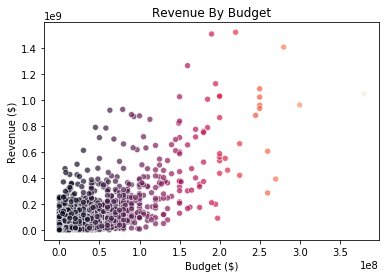

In [99]:
# initial plotting comparing some major features
# budget
sns.scatterplot(x="budget", y="revenue", hue='budget', alpha=.7, palette="rocket", data=train)
plt.legend([],[], frameon=False)
plt.xlabel('Budget ($)')
plt.ylabel('Revenue ($)')
plt.title('Revenue By Budget')

plt.show()

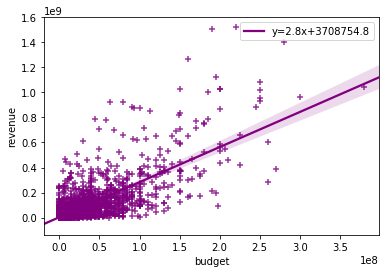

In [100]:
# with regression
# get coeffs of linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(train['budget'],train['revenue'])
ax = sns.regplot(x="budget", y="revenue", data=train, marker='+', color='purple', line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})

# plot legend
ax.legend()

plt.show()

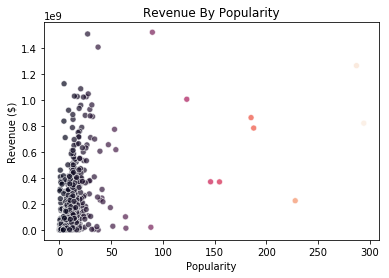

In [101]:
# initial plotting
# popularity
sns.scatterplot(x="popularity", y="revenue", hue='popularity', alpha=.7, palette="rocket", data=train)
plt.legend([],[], frameon=False)
plt.xlabel('Popularity')
plt.ylabel('Revenue ($)')
plt.title('Revenue By Popularity')

plt.show()

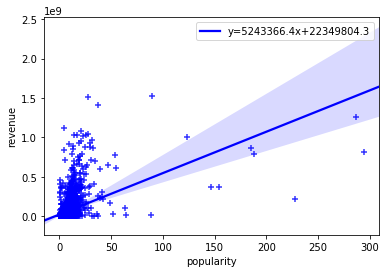

In [102]:
# with regression
# get coeffs of linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(train['popularity'],train['revenue'])
ax = sns.regplot(x="popularity", y="revenue", data=train, marker="+", color='blue', line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})

# plot legend
ax.legend()

plt.show()

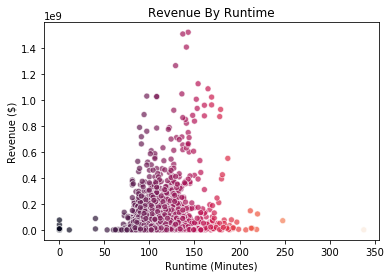

In [103]:
# initial plotting
# runtime
sns.scatterplot(x="runtime", y="revenue", hue='runtime', alpha=.7, palette="rocket", data=train, legend="full")
plt.legend([],[], frameon=False)
plt.xlabel('Runtime (Minutes)')
plt.ylabel('Revenue ($)')
plt.title('Revenue By Runtime')

plt.show()

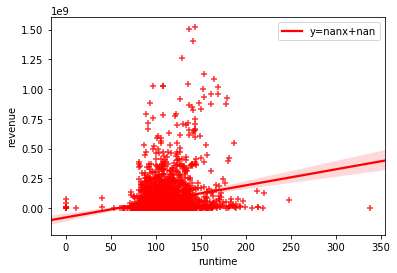

In [104]:
# with regression
# get coeffs of linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(train['runtime'],train['revenue'])
ax = sns.regplot(x="runtime", y="revenue", data=train, marker="+", color='red', line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})

# plot legend
ax.legend()

plt.show()

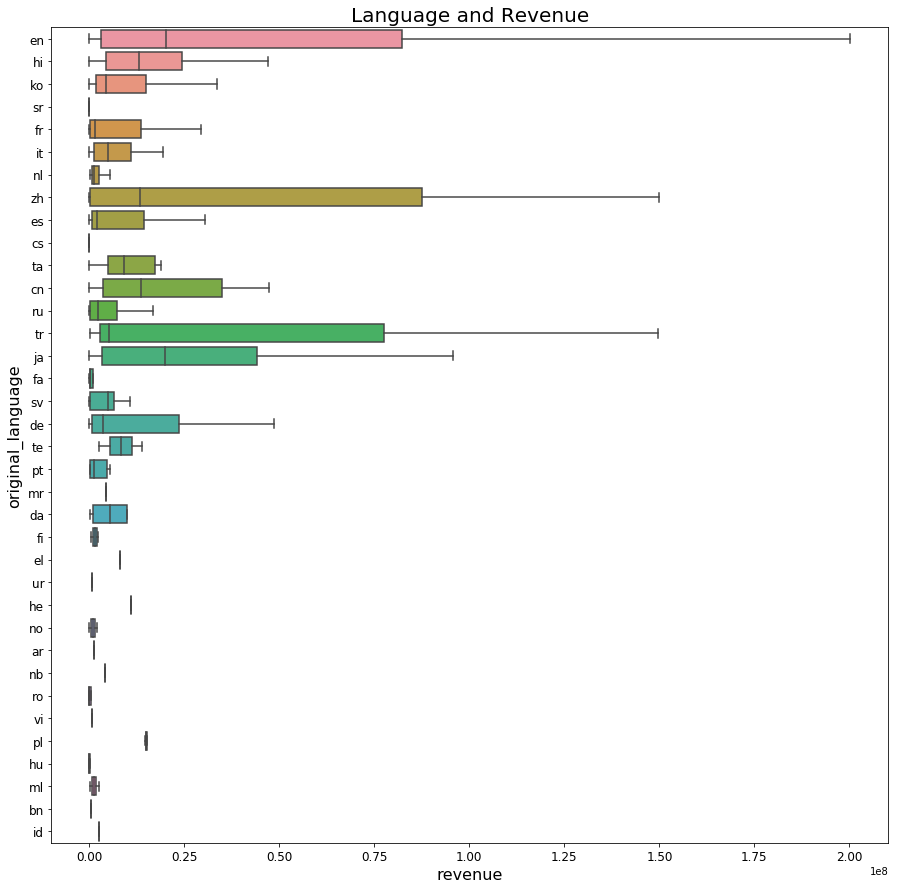

In [105]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.tick_params(axis='both', labelsize=12)
plt.title('Language and Revenue', fontsize=20)
plt.xlabel('Revenue ($)', fontsize=16)
plt.ylabel('Language', fontsize=16)
sns.boxplot(ax=ax, x='revenue', y='original_language', data=train, showfliers=False, orient='h')
plt.show()

In [106]:
genres = []
repeated_revenues = []
for i in range(len(train)):
    if train['genres'][i] == train['genres'][i]:
        movie_genre = [genre['name'] for genre in eval(train['genres'][i])]
        genres.extend(movie_genre)
        repeated_revenues.extend([train['revenue'][i]]*len(movie_genre))

genre = pd.DataFrame(np.zeros((len(genres), 2)))
genre.columns = ['genre', 'revenue']
genre['genre'] = genres
genre['revenue'] = repeated_revenues

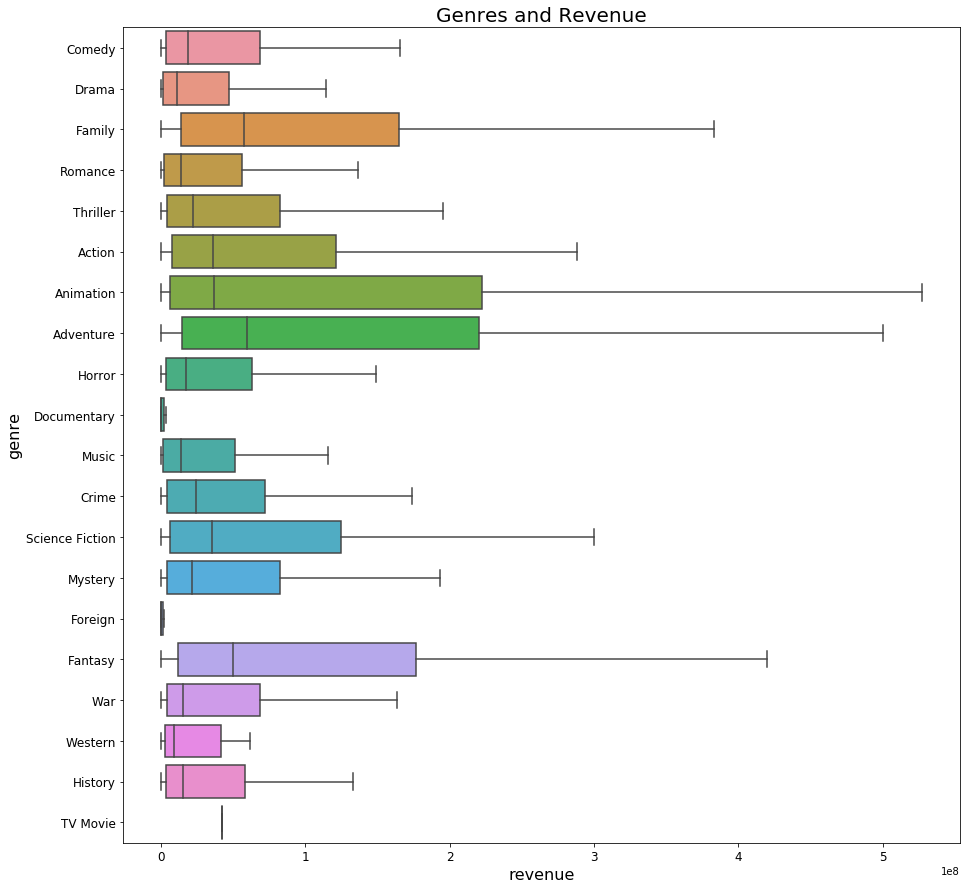

In [107]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.tick_params(axis='both', labelsize=12)
plt.title('Genres and Revenue', fontsize=20)
plt.xlabel('revenue', fontsize=16)
plt.ylabel('genre', fontsize=16)
sns.boxplot(ax=ax, x=repeated_revenues, y=genres, showfliers=False, orient='h')
plt.show()

In [108]:
#Adding production_companies count for data
prod_comp_count=[]
for i in train['production_companies']:
    if(not(pd.isnull(i))):
        
        prod_comp_count.append(len(eval(i)))
        
    else:
        prod_comp_count.append(0)
train['num_prod_companies'] = prod_comp_count

Text(0.5, 1.0, 'Revenue for different number of production companies in the film')

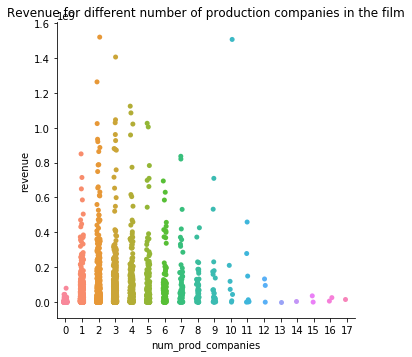

In [109]:
#number of prod companies vs revenue
sns.catplot(x='num_prod_companies', y='revenue', data=train)
plt.title('Revenue for different number of production companies in the film')

In [110]:
#Adding production_countries count for data
prod_country_count=[]
for i in train['production_countries']:
    if(not(pd.isnull(i))):
        
        prod_country_count.append(len(eval(i)))
        
    else:
        prod_country_count.append(0)
train['num_prod_countries'] = prod_country_count

Text(0.5, 1.0, 'Revenue for different number of production countries in the film')

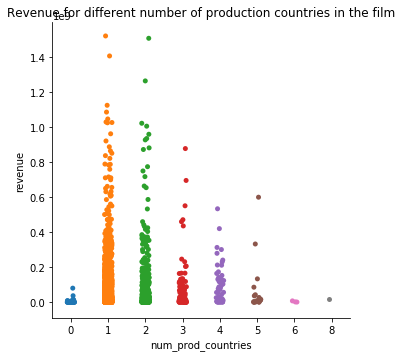

In [111]:
#number of prod companies vs revenue
sns.catplot(x='num_prod_countries', y='revenue', data=train)
plt.title('Revenue for different number of production countries in the film')

Text(0.5, 1.0, 'Movies revenues with and without homepage')

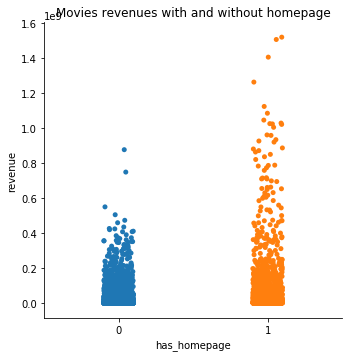

In [112]:
# how having homepage affects revenue
train['has_homepage'] = 0
train.loc[train['homepage'].isnull() == False, 'has_homepage'] = 1
test['has_homepage'] = 0
test.loc[test['homepage'].isnull() == False, 'has_homepage'] = 1


sns.catplot(x='has_homepage', y='revenue', data=train)
plt.title('Movies revenues with and without homepage')

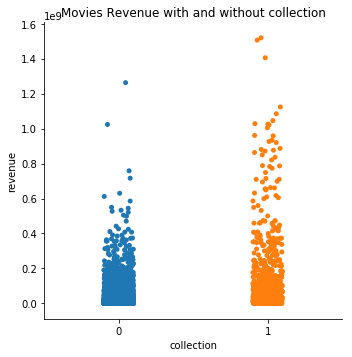

In [113]:
#Converting collections as binary
train['collection'] = 0
train.loc[train['belongs_to_collection'].isnull() == False, 'collection'] = 1
test['collection'] = 0
test.loc[test['belongs_to_collection'].isnull() == False, 'collection'] = 1

#collections v/s Revenue
sns.catplot(x='collection', y='revenue', data=train);
plt.title('Movies Revenue with and without collection');

In [114]:
# cast
total_cast=[]
for i in train['cast']:
    if(not(pd.isnull(i))):
        
        total_cast.append(len(eval(i)))
        
    else:
        total_cast.append(0)
train['cast_count'] = total_cast

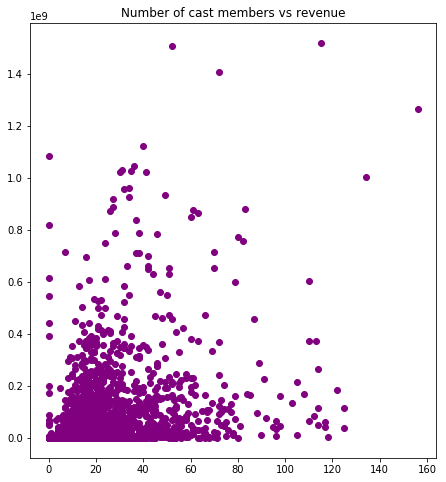

In [115]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(train['cast_count'], train['revenue'], color='purple')
plt.title('Number of cast members vs revenue');

In [116]:
# crew
total_crew=[]
for i in train['crew']:
    if(not(pd.isnull(i))):
        
        total_crew.append(len(eval(i)))
        
    else:
        total_crew.append(0)
train['crew_count'] = total_crew

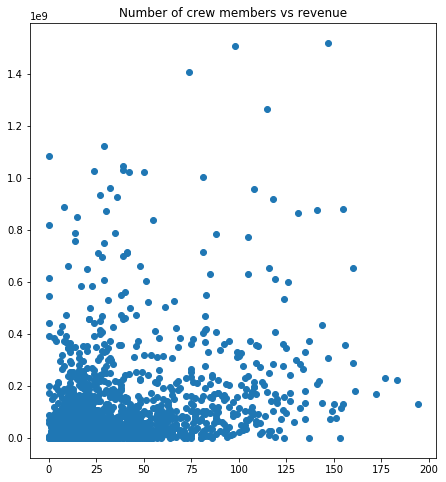

In [117]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(train['crew_count'], train['revenue'])
plt.title('Number of crew members vs revenue');

In [118]:
#Check how revenue depends of day
train['release_date'] = pd.to_datetime(train['release_date'])
test['release_date'] = pd.to_datetime(test['release_date'])

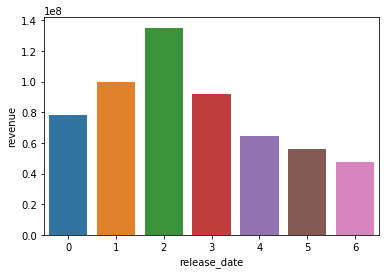

In [119]:
release_day = train['release_date'].value_counts().sort_index()
release_day_revenue = train.groupby(['release_date'])['revenue'].sum()
release_day_revenue.index = release_day_revenue.index.dayofweek
sns.barplot(release_day_revenue.index,release_day_revenue, data = train,ci=None)
plt.show()

In [120]:
#keywords
Keywords_count=[]
for i in train['Keywords']:
    if(not(pd.isnull(i))):
        
        Keywords_count.append(len(eval(i)))
        
    else:
        Keywords_count.append(0)
train['Keywords_count'] = Keywords_count

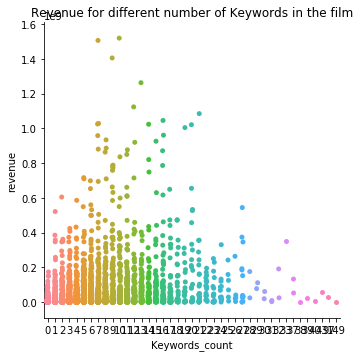

In [121]:
sns.catplot(x='Keywords_count', y='revenue', data=train);
plt.title('Revenue for different number of Keywords in the film');

### EDA Results

Movies with fewer production companies and countries typically yield more revenue. Movies with a homepage tend to yield more revenue, but there are a substantial amount that don't have one that still have good revenue. This could potentially be that this doesn't account whether the film might have a social media page on Instagram, Facebook, etc.

Films that are part of a collection also tend to yield more revenue, but again there are a substantial amount that do fine on their own, including cult classics not part of a series.

The most popular film genres appear to be Animation and Adventure, followed by Family and Adventure. I found this to be surprising, as I had expected Action to be more popular, but this might only be biased by my experience in the US, and there could be a significant favor for these genres in other countries that sway the result. 

Highest revenue movies are in: English, Chinese and Turkish. Japanese is also extremely popular as well, which could explain the popularity of animated films.

Both cast and crew count look very similar, with revenue peaking at around 20-40 people. However that is also just the main crew listed on this database; in actuality, we know it takes many more crew, on the order of hundreds or thousands, to make a film come together.

Wednesday surprisingly appears to be the most popular release day for best revenue.

Films with around 7-11 keywords seem to generate the best revenue.

## Data Cleaning

Need to extract data from dictionaries in columns; some have 1, some have several

In [122]:
# use it for one-hot encoding. Will define functions to extract items from 
# dictionaries for each row and hot encode them.
mlb = MultiLabelBinarizer()

exctraction and encoding code taken from https://www.kaggle.com/dway88/feature-eng-feature-importance-random-forest

In [123]:
def convertStringToList(strVal):
    if type(strVal) is not str:
        return  []
    else:
        return ast.literal_eval(strVal)

In [124]:
def formatDictColumnAndExtractNames(strVal):
    listOfItems = convertStringToList(strVal)
    return list(map(lambda x: x['name'], listOfItems))

In [125]:
# first extract genres column
def extractGenres(df):
    genreCount = df['genres'].apply(formatDictColumnAndExtractNames)
    df['genreCount'] = genreCount.apply(lambda x: len(x))
    return df

In [126]:
train = extractGenres(train)
test = extractGenres(test)

In [127]:
# next extract production companies, keep the companies that appear more than 30 times
def extractCommonProdCompanies(df):
    prodcompCount = df['production_companies'].apply(formatDictColumnAndExtractNames)
    df['prodcompCount'] = prodcompCount.apply(lambda x: len(x))
    return df

In [128]:
train = extractCommonProdCompanies(train)
test = extractCommonProdCompanies(test)

In [129]:
# next extract production countries, keep the companies that appear more than 30 times
def extractCommonProdCountries(df):
    prodcountryCount = df['production_countries'].apply(formatDictColumnAndExtractNames)
    df['prodcountryCount'] = prodcountryCount.apply(lambda x: len(x))
    return df

In [130]:
train = extractCommonProdCountries(train)
test = extractCommonProdCountries(test)

In [131]:
# change release date to acceptable format
train['release_date'] = pd.to_datetime(train['release_date'])
test['release_date'] = pd.to_datetime(test['release_date'])

In [132]:
#adding day feature to the data

train['release_day'] = train['release_date'].dt.dayofweek 
test['release_day'] = test['release_date'].dt.dayofweek 

#filling nulls
train['release_day'] = train['release_day'].fillna(0)
test['release_day'] = test['release_day'].fillna(0)

In [133]:
# extract spoken languages, get language count
def extractCommonSpokenLanguages(df):

    languageCount = df['spoken_languages'].apply(formatDictColumnAndExtractNames)
    df['languageCount'] = languageCount.apply(lambda x: len(x))
    return df

In [134]:
train = extractCommonSpokenLanguages(train)
test = extractCommonSpokenLanguages(test)

In [135]:
# extract keywords, keep keywords that appear more than 30 times
def extractCommonKeywords(df):
    keywordCount = df['Keywords'].apply(formatDictColumnAndExtractNames)
    df['keywordCount'] = keywordCount.apply(lambda x: len(x))
    return df

In [136]:
train = extractCommonKeywords(train)
test = extractCommonKeywords(test)

In [137]:
# extract cast names, create cast length column
def addCastLengthColumn(df):
    castNames = df['cast'].apply(formatDictColumnAndExtractNames)
    df['cast_len'] = castNames.apply(lambda x: len(x))
    return df

In [138]:
train = addCastLengthColumn(train)
test = addCastLengthColumn(test)

In [139]:
# extract crew names and create new columns by job and crew length column
def formatDictColumnAndExtractJobName(strVal, job):
    listOfItems = convertStringToList(strVal)
    
    jobItem = (list(filter(lambda lst: lst['job'] == job, listOfItems)) or [None])[0]
    if type(jobItem) is dict:
        return jobItem['name']
    else:
        return None

In [140]:
def addCrewLengthColumn(df):
    df['crew'] = df['crew'].apply(formatDictColumnAndExtractNames)
    df['crew_len'] = df['crew'].apply(lambda x: len(x))
    return df

In [141]:
train = addCrewLengthColumn(train)
test = addCrewLengthColumn(test)

In [142]:
# categorize if movie has homepage or not
train['has_homepage'] = train['homepage'].apply(lambda x: isinstance(x, str))
test['has_homepage'] = test['homepage'].apply(lambda x: isinstance(x, str))

In [143]:
# catgorize if film is part of collection or not
train['belongs_to_collection'] = train['belongs_to_collection'].apply(lambda x: isinstance(x, str))
test['belongs_to_collection'] = test['belongs_to_collection'].apply(lambda x: isinstance(x, str))


In [144]:
# exctract tagline info 
def extractTaglineInfo(df):
    df['has_tagline'] = df['tagline'].apply(lambda x: isinstance(x, str))
    df['tagline_len'] = df['tagline'].apply(lambda x: len(x) if isinstance(x, str) else 0)
    return df

In [145]:
train = extractTaglineInfo(train)
test = extractTaglineInfo(test)

In [146]:
# extract overview info 
def extractOverviewInfo(df):
    df['has_overview'] = df['overview'].apply(lambda x: isinstance(x, str))
    df['overview_len'] = df['overview'].apply(lambda x: len(x) if isinstance(x, str) else 0)
    return df

In [147]:
train = extractOverviewInfo(train)
test = extractOverviewInfo(test)

In [148]:
remove_columns = ['id','homepage', 'imdb_id','original_title', 
                  'overview','poster_path', 'tagline', 'cast', 
                  'crew', 'status', 'title', 'release_date',
                 'genres', 'Keywords', 'production_companies', 
                  'production_countries', 'spoken_languages', 
                  'original_language']

train.drop(remove_columns, axis=1, inplace=True)

test.drop(['homepage', 'imdb_id','original_title', 
                  'overview','poster_path', 'tagline', 'cast', 
                  'crew', 'status', 'title', 'release_date',
                 'genres', 'Keywords', 'production_companies', 
                  'production_countries', 'spoken_languages', 
                  'original_language'], axis=1, inplace=True)

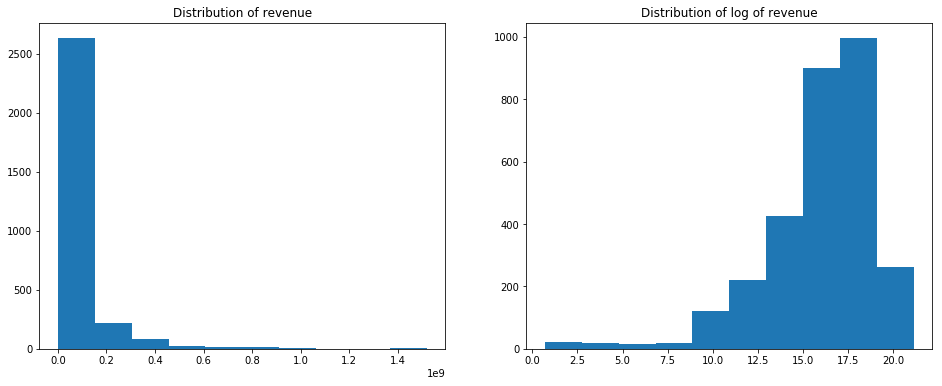

In [149]:
fig, ax = plt.subplots(figsize = (16, 6))
plt.subplot(1, 2, 1)
plt.hist(train['revenue']);
plt.title('Distribution of revenue');
plt.subplot(1, 2, 2)
plt.hist(np.log1p(train['revenue']));
plt.title('Distribution of log of revenue');

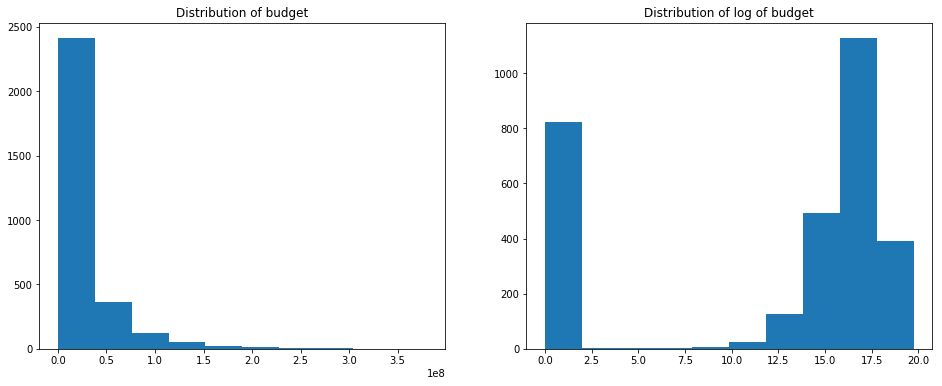

In [150]:
fig, ax = plt.subplots(figsize = (16, 6))
plt.subplot(1, 2, 1)
plt.hist(train['budget']);
plt.title('Distribution of budget');
plt.subplot(1, 2, 2)
plt.hist(np.log1p(train['budget']));
plt.title('Distribution of log of budget');

In [151]:
# we will want to use Root-Mean-Squared-Logarithmic-Error (RMSLE) between the 
# predicted revenue and the actual revenue. revenue distribution is skewed
train.revenue = np.log1p(train.revenue)

train['budget'] = np.log1p(train['budget'])
test['budget'] = np.log1p(test['budget'])

In [152]:
# to do Pearson correlation of features, have to have numerical values

In [153]:
train["belongs_to_collection"] = train["belongs_to_collection"].astype(int)
test["belongs_to_collection"] = test["belongs_to_collection"].astype(int)

train["has_tagline"] = train["has_tagline"].astype(int)
test["has_tagline"] = test["has_tagline"].astype(int)

train["has_homepage"] = train["has_homepage"].astype(int)
test["has_homepage"] = test["has_homepage"].astype(int)

train["has_overview"] = train["has_overview"].astype(int)
test["has_overview"] = test["has_overview"].astype(int)

In [154]:
# there are movies with budget 0 in original train, so take these out
train = train[train['budget'] >= 0]
test = test[test['budget'] >= 0]

In [155]:
# for the columns we found with NaN values, will fill these with values that make sense
fillna_columns = {'release_day':'mode',
                  'belongs_to_collection': '0',
                  'runtime': 'mode'}

for k,v in fillna_columns.items():
    if v == 'mode':
        fill = train[k].mode()[0]
    else:
        fill = v
    print(k, ': ', fill)
    train[k] = train[k].fillna(value = fill)
    test[k] = test[k].fillna(value = fill)

release_day :  4
belongs_to_collection :  0
runtime :  90.0


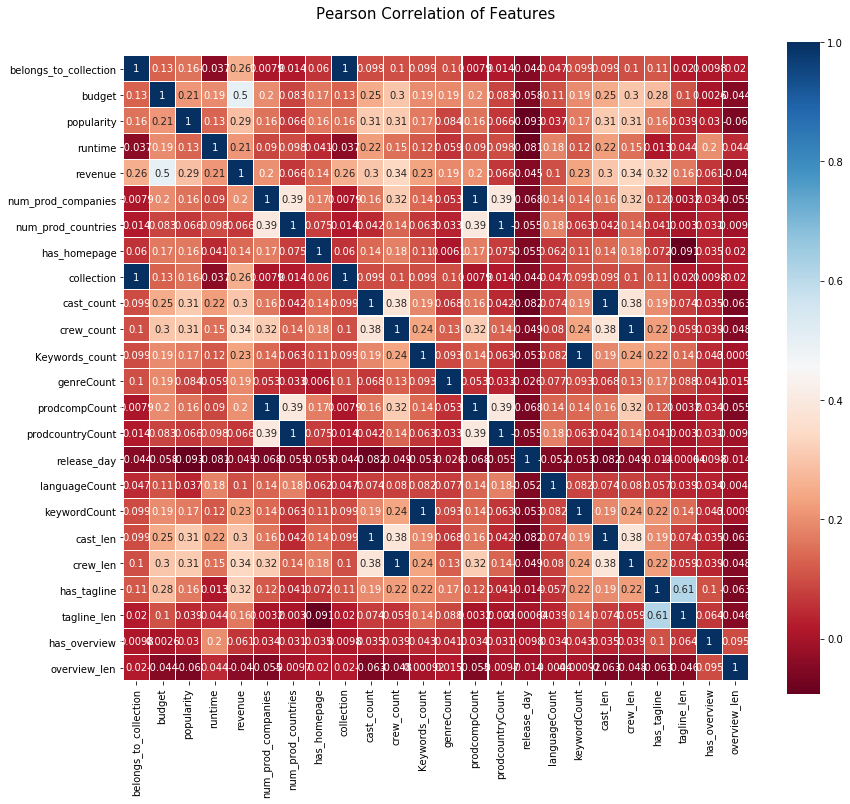

In [156]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

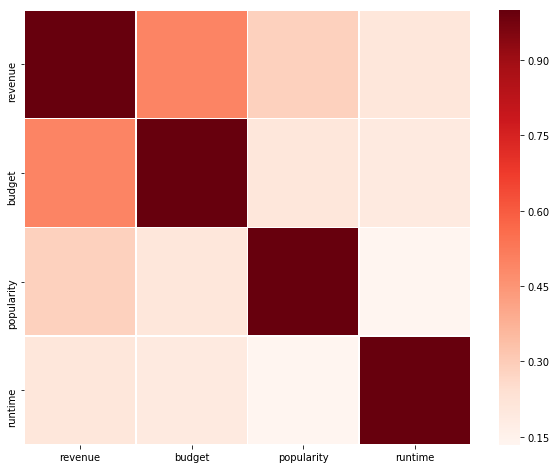

In [157]:
col = ['revenue','budget','popularity','runtime']

plt.subplots(figsize=(10, 8))

corr = train[col].corr()

sns.heatmap(corr, xticklabels=col,yticklabels=col, linewidths=.5, cmap="Reds")

## Training the Model

Because we have a dataset with <100k samples, and we are trying to precict a changing quantity (revenue) rather than a discrete category/value, we will want to use regression. We have many factors at play rather than just a few of importance, so we will likely need to use a model like SVR(kernel='linear'). We will compare with a few other models like Ridge Regression just to measure performance.

## Model 1: Support Vector Regression

In [158]:
#target = revenue
X = train.drop(['revenue'], axis=1)
y = train['revenue']
y = pd.DataFrame(y)
X_test = test.copy(deep=True)

In [159]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [160]:
# we expect linear to be the best kernel param
model = SVR()
params = {'C': [1e0, 1e1, 1e2, 1e3], "gamma": [0,100]}

svr_clf = GridSearchCV(model, params)
svr_clf.fit(X_train, y_train)
svr_clf.score(X_train, y_train)* 100

98.26083019028933

In [161]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(svr_clf, X, y, scoring="neg_mean_squared_error", cv = 10)
rmse_scores = np.sqrt(-scores)
print(rmse_scores.mean())

3.0575322788024293


In [162]:
svr_clf.best_params_

{'C': 10.0, 'gamma': 100}

In [163]:
# hypertune parameters
svr = SVR(kernel='linear',C=10.0, gamma=100)
svr.fit(X_train, y_train)

SVR(C=10.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=100,
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [164]:
svr.coef_

array([[ 5.79735713e-01,  9.98959208e-02,  3.93780836e-02,
         1.20700694e-02,  3.66137183e-02, -6.14831657e-02,
         1.91887160e-01,  5.79735713e-01,  5.56245660e-03,
         5.22347577e-03,  1.08062043e-03,  2.47439990e-01,
         3.66137183e-02, -6.14831657e-02,  8.24592521e-04,
         5.21731398e-02,  1.08062043e-03,  5.56245660e-03,
         5.22347577e-03,  9.36772607e-01,  1.60733513e-03,
        -4.21192894e-01, -6.31239986e-04]])

## Model 2: Kernel ridge regression

In [165]:
model = KernelRidge()
params = {'kernel':['linear','rbf'],'gamma':[0,100], "alpha": [1e0, 0.1, 1e-2, 1e-3]}
kr_clf = GridSearchCV(model, params)
kr_clf.fit(X_train, y_train)
kr_clf.score(X_train, y_train)* 100

35.89571495792286

In [166]:
scores = cross_val_score(kr_clf, X, y, scoring="neg_mean_squared_error", cv = 10)
rmse_scores = np.sqrt(-scores)
print(rmse_scores.mean())

2.471286171686874


In [167]:
kr_clf.best_params_

{'alpha': 0.001, 'gamma': 0, 'kernel': 'linear'}

In [168]:
# hypertune parameters
kr = KernelRidge(alpha= 0.001, gamma=0, kernel='linear')
kr.fit(X_train, y_train)

KernelRidge(alpha=0.001, coef0=1, degree=3, gamma=0, kernel='linear',
      kernel_params=None)

## Model 3: Linear regression

In [169]:
# Linear regression
from sklearn.linear_model import LinearRegression
model = LinearRegression()
params = {'n_jobs':[0,100]}
clf = GridSearchCV(model, params)
clf.fit(X_train, y_train)
clf.score(X_train, y_train)* 100

38.47245986290822

In [170]:
clf.best_params_

{'n_jobs': 0}

In [171]:
scores = cross_val_score(clf, X, y, scoring="neg_mean_squared_error", cv = 8)
rmse_scores = np.sqrt(-scores)
print(rmse_scores.mean())

2.430191976464066


In [172]:
# hypertune parameters
lr = LinearRegression(n_jobs=0)
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=0, normalize=False)

## Model 4: Random Forest regression

In [173]:
# Random forest regression
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()
params = {'n_estimators':[1,100],'max_depth':[1,100],'min_samples_split':[2,10],'min_samples_leaf':[1,10],'max_leaf_nodes':[2,100]}
clf = GridSearchCV(model, params)
clf.fit(X_train, y_train)
clf.score(X_train, y_train)* 100

64.71073987543323

In [174]:
clf.best_params_

{'max_depth': 100,
 'max_leaf_nodes': 100,
 'min_samples_leaf': 10,
 'min_samples_split': 2,
 'n_estimators': 100}

In [175]:
regr = RandomForestRegressor(max_depth= 100, max_leaf_nodes=100, min_samples_leaf=10,
                             min_samples_split=10, n_estimators=100)
scores = cross_val_score(regr, X, y, scoring="neg_mean_squared_error", cv = 10)
rmse_scores = np.sqrt(-scores)
print(rmse_scores.mean())

2.218424960716398


In [176]:
# Random Forest appears to have the best score
regr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=100,
           max_features='auto', max_leaf_nodes=100,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

## Bonus Model 5: XGB regression

In [177]:
# also trying XGBRegressor out of curiosity, not part of sklearn
from xgboost import XGBRegressor

xgbr = XGBRegressor()
xgbr.fit(X_train, y_train)
xgbr.score(X_train, y_train)* 100

61.90264155752465

In [178]:
scores = cross_val_score(xgbr, X, y, scoring="neg_mean_squared_error", cv = 10)
rmse_scores = np.sqrt(-scores)
print(rmse_scores.mean())

2.18964755191064


## Final predictions
Training the final model with full test dataset and exporting predictions

In [1]:
final_predict = svr.predict(X_test)
pd.DataFrame({'id': test.id, 'revenue': final_predict}).to_csv('./submission.csv')

NameError: name 'svr' is not defined

# Conclusion & Final Thoughts

Final Scores (RMSE mean, Accuracy)

Support Vector Regression: 3.06, 99.89

Kernel Ridge Regression: 2.47, 35.01

Linear Regression: 2.43, 38.15

Random Forest Regressor: 2.21, 2.21

XGBRegressor: 2.2, 62.2

After looking at https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html I decided to try the Support Vector Regression as I hypothesized this would likely fit best given my dataset and target, then compare to several other regression models. As expected, this had the best accuracy and RMSE mean score.